## Import dependencies

In [25]:
import pandas as pd
import seaborn as sns
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import joblib

## Read data

In [26]:
X_train = pd.read_csv("../data/train_test/X_train.csv",header=None)
X_test = pd.read_csv("../data/train_test/X_test.csv", header=None)
y_train = pd.read_csv("../data/train_test/y_train.csv", header=None)
y_test = pd.read_csv("../data/train_test/y_test.csv", header=None)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().reshape(-1,)
y_test = y_test.to_numpy().reshape(-1,)

## Build pipeline

### Select classifier 

First, I test some classifier, than I can choose one for parameter optimization to get better results.

In [27]:

knc = KNeighborsClassifier()
lr = LogisticRegression(solver="newton-cg")
svc = SVC()
rfc = RandomForestClassifier()
nbc = MultinomialNB()
#gbc = GradientBoostingClassifier()
bc = BaggingClassifier()

ml_models = models = {"knc": knc, "lr": lr, "svc": svc, "rfc": rfc,
                      'nb' : MultinomialNB(),
                       'bc' : BaggingClassifier()}

In [28]:
def initial_model(X_train, X_test, y_train, y_test, ml_models):
    
    
    
    for model in ml_models:
          
        if model != 'nb':
            
            pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('scaler', StandardScaler()), (model, ml_models[model])])
        else:
            
            pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('minmax',MinMaxScaler()), (model, ml_models[model])])
        
        start_train = time.time()
        pipe.fit(X_train, y_train)
        train_time = round(time.time()-start_train,1)
        
        accuracy = accuracy_score(y_test,pipe.predict(X_test))
        recall = recall_score(y_test,pipe.predict(X_test), average=None)
        precision = precision_score(y_test,pipe.predict(X_test), average=None)
        f1 = f1_score(y_test,pipe.predict(X_test), average=None)
        
        print('*'*20)
        print(f'Scores of {model}:')
        print('*'*20)
        print(f'Train time: {train_time}s')
        print(f'Accuracy score: {accuracy}')
        print('\n')
        print(f'Recall score: {recall}')
        print('\n')
        print(f'Precision score: {precision}')
        print('\n')
        print(f'F1 score: {f1}')
        print('\n')
    

In [29]:
initial_model(X_train,X_test,y_train,y_test,ml_models)

********************
Scores of knc:
********************
Train time: 0.5s
Accuracy score: 0.9432750624331074


Recall score: [0.98795181 0.98756219 0.98113208 0.86104784 0.91983968 0.99781659
 0.76470588 0.93333333 0.93023256 0.75       0.84615385 0.71794872]


Precision score: [0.95571096 0.97783251 0.98913043 0.91084337 0.88610039 0.99132321
 1.         0.77777778 0.85106383 0.79411765 0.93617021 0.82352941]


F1 score: [0.97156398 0.98267327 0.98511502 0.8852459  0.90265487 0.9945593
 0.86666667 0.84848485 0.88888889 0.77142857 0.88888889 0.76712329]


********************
Scores of lr:
********************
Train time: 8.4s
Accuracy score: 0.96931858722797


Recall score: [0.98313253 0.99751244 0.99730458 0.94077449 0.93186373 1.
 0.88235294 1.         0.93023256 0.94444444 0.90384615 0.92307692]


Precision score: [0.99512195 0.98525799 0.9919571  0.921875   0.94512195 0.99565217
 0.96774194 1.         0.93023256 0.94444444 0.95918367 0.92307692]


F1 score: [0.98909091 0.99134734 

## Final model

In the initial test, in the previous section I tried out some of the classification models in sklearn. There are some model with really high accuracy. Most of the models without any parameter tuning, show us a high accuracy. The fastest model was the `Naive Bayes` but the accuracy wasn't so high. The `Random Forest Classifier` has the highest accuracy score, and the calculation speed is not so bad. I will test out this model. 

### RandomForestClassifier 

In [30]:
rfc_params = {'rfc__n_estimators' : [20,50,100,200],
              'rfc__min_samples_split' : [2, 5, 10],
              'rfc__min_samples_leaf' : [1,2,5,10]} 

In [31]:
 def random_search(model, params):
        
    pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('scaler', StandardScaler()), ("rfc", model)])
                     
    search = GridSearchCV(pipe, param_grid=params)
    
    return search

In [32]:
model = random_search(RandomForestClassifier(),rfc_params)

In [33]:
model.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                                       ('scaler', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__min_samples_leaf': [1, 2, 5, 10],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [20, 50, 100, 200]})

In [37]:
model.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                ('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=200))])

In [41]:
best = model.best_estimator_

start_train = time.time()
train_time = round(time.time()-start_train,1)

accuracy = accuracy_score(y_test,best.predict(X_test))
recall = recall_score(y_test,best.predict(X_test), average=None)
precision = precision_score(y_test,best.predict(X_test), average=None)
f1 = f1_score(y_test,best.predict(X_test), average=None)

print('*'*20)
print(f'Scores of {best}:')
print('*'*20)
print(f'Train time: {train_time}s')
print(f'Accuracy score: {accuracy}')
print('\n')
print(f'Recall score: {recall}')
print('\n')
print(f'Precision score: {precision}')
print('\n')
print(f'F1 score: {f1}')
print('\n')
    

********************
Scores of Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                ('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=200))]):
********************
Train time: 0.0s
Accuracy score: 0.9732429539778809


Recall score: [0.99277108 0.98258706 0.98113208 0.96810934 0.96793587 1.
 0.94117647 0.93333333 0.86046512 0.75       0.92307692 0.84615385]


Precision score: [0.97399527 0.9875     0.99453552 0.96153846 0.96987952 0.99782135
 0.94117647 1.         0.90243902 0.81818182 0.90566038 0.825     ]


F1 score: [0.98329356 0.98503741 0.98778833 0.96481271 0.96890672 0.99890949
 0.94117647 0.96551724 0.88095238 0.7826087  0.91428571 0.83544304]




In [43]:
scores = cross_val_score(best, X_train, y_train, cv=3)

In [44]:
print('Accuracy of the model: {}% ±{}%'.format(round(np.mean(scores)*100,2), round(np.std(scores)*100,2)))

Accuracy of the model: 97.84% ±0.26%


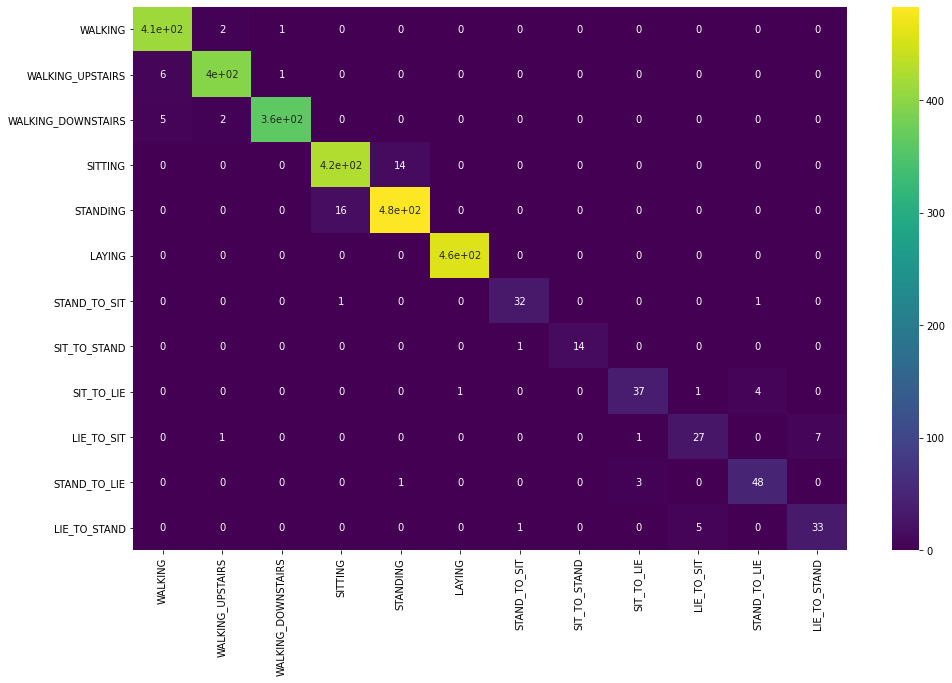

In [46]:
plt.figure(figsize=(16,10))
sns.heatmap(confusion_matrix(y_test,model.predict(X_test)), annot=True, cmap="viridis",
            xticklabels=["WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"],
            yticklabels=["WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"])

###  Saving the final model

In [47]:
import joblib

In [48]:
def save_model(model):
    '''Save the model to disk'''
    
    filename = '../models/har_model_v14.sav'
    joblib.dump(model, filename)
    readme = open('../models/ml_model_v14.txt', 'w')
    readme.write('Ml model with rfc, with overlap 97.84% ±0.26% accuracy.')
    readme.close()

In [49]:
save_model(model)